# Learning curves
Evaluate and save some learning curves with the aging problem.

In [52]:
import cPickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-paper')
plt.rc('text', usetex=False)

import warnings
warnings.filterwarnings('ignore')

# 0. Load raw data

In [53]:
df = pd.read_csv('../../data/aging_data.csv', header=0, index_col=0)
features = df.columns.drop('age')
print('- Raw data loaded.')

- Raw data loaded.


# 0.1 Split data/labels

In [54]:
raw_data = df[features]
labels = df['age']
print('- {} samples / {} features.'.format(*raw_data.shape))

- 118 samples / 12 features.


# 0.2 Preprocess raw data

In [55]:
from sklearn.preprocessing import PolynomialFeatures
from fancyimpute import KNN
import pandas as pd

def preprocess(dfx, poly_feat=False):
    """Categorical feature mapping + KNN imputing.

    dfx: input data DataFrame object with shape (n,d)
    """
    # 1. Convert gender [m/f] in [0,1]
    dfx.loc[:, 'gender'] = dfx['gender'].apply(lambda x: int(x == 'f'))

    # 2. Impute missing values via KNN
    dfx = pd.DataFrame(data=KNN(k=3).complete(dfx.values),
                       index=dfx.index, columns=dfx.columns)

    # 3. If needed, compute polynomial features
    if poly_feat:
        polyfeat = PolynomialFeatures(degree=2, include_bias=True)
        dfx_values = polyfeat.fit_transform(dfx.values)
        dfx_columns = polyfeat.get_feature_names(dfx.columns)
        dfx = pd.DataFrame(data=dfx_values,
                           index=dfx.index,
                           columns=dfx_columns)

    return dfx

data_linfeat = preprocess(raw_data, poly_feat=False)
data_polyfeat = preprocess(raw_data, poly_feat=True)
data_polyfeat = data_polyfeat.drop('gender^2', axis=1) # drop nonsense feature

Imputing row 1/118 with 0 missing, elapsed time: 0.004
Imputing row 101/118 with 0 missing, elapsed time: 0.004
Imputing row 1/118 with 0 missing, elapsed time: 0.004
Imputing row 101/118 with 0 missing, elapsed time: 0.005


# 0.3 Define cross-validated pipeline

In [56]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([['preproc', StandardScaler()],
                 ['predict', Ridge()]])
pipe_cv = GridSearchCV(pipe, param_grid={'predict__alpha': np.logspace(-3, 2, 30)}, cv=5)

# 1. Make learning curves

In [57]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(train_sizes, train_scores, test_scores,
                        title='title', ylabel='score', dpi=200):
    """Generate a simple plot of the test and training learning curve."""
    plt.figure(dpi=dpi)
    plt.title(title)
    plt.xlabel("# Training examples")
    plt.ylabel(ylabel)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="orange")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="royalblue")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="orange",
             label="Training error")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="royalblue",
             label="Cross-validation error")

    plt.legend(loc="best")
    return plt

In [58]:
# Try linear feature first
data = data_linfeat

train_sizes, train_scores, test_scores = learning_curve(
    pipe_cv, data, labels, cv=ShuffleSplit(n_splits=100, test_size=0.1), n_jobs=-1, train_sizes=np.linspace(0.1, 1, 20),
    scoring='mean_absolute_error')

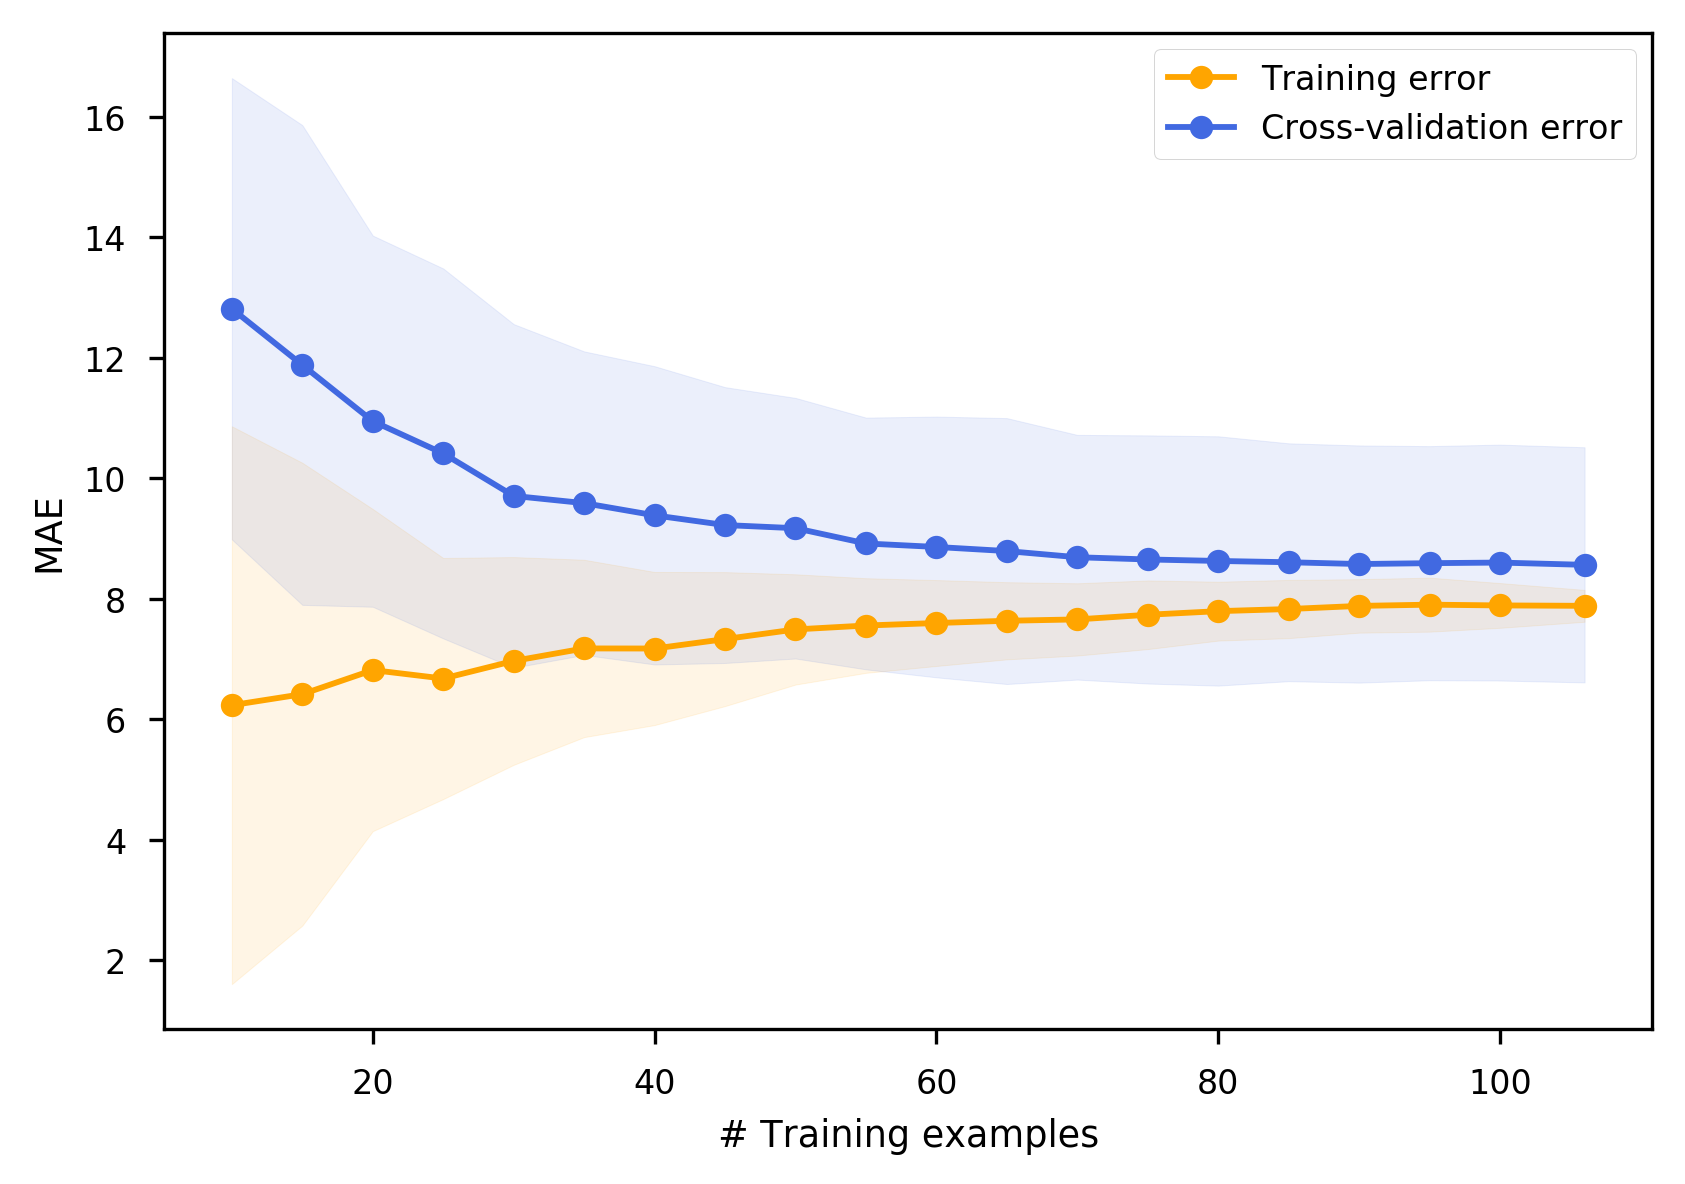

In [ ]:
plt = plot_learning_curve(train_sizes, -train_scores, -test_scores, '', 'MAE', 300)
plt.savefig('../../images/aging_learning_curve_linfeat.png')

In [ ]:
# Try polynomial feature first
data = data_polyfeat

train_sizes, train_scores, test_scores = learning_curve(
    pipe_cv, data, labels, cv=ShuffleSplit(n_splits=100, test_size=0.1), n_jobs=-1, train_sizes=np.linspace(0.1, 1, 20),
    scoring='mean_absolute_error')

In [ ]:
plt = plot_learning_curve(train_sizes, train_scores, test_scores, '', 'MAE', 300)
plt.savefig('../../images/aging_learning_curve_polyfeat.png')